In [37]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from src.utils import *

# Generate data

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:48: RuntimeWarning:

overflow encountered in power



(np.float64(0.008802859493200033), np.float64(14.955679403672631), (937, 100))

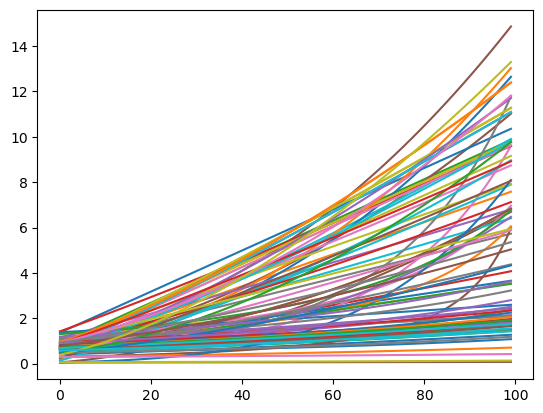

In [39]:
length = 100
n0 = 20
paris_episodes = np.empty((0, length))
for c in np.arange(0.01, .1, .02):
    for m in np.arange(0.01, 4, .2):
        paris = ParisLawDegradation(length=length, dim=1, c=c, m=m)
        episodes_i = paris.generate_episode(x0=np.abs(np.random.randn(n0)*0.3+0.7))  # Initial crack lengths in meters
        paris_episodes = np.concatenate([paris_episodes, episodes_i], axis=0)

#drop invalid values
paris_episodes = paris_episodes[~np.isnan(paris_episodes).any(axis=1)]
paris_episodes = paris_episodes[(paris_episodes<15).all(axis=1)]
paris_episodes = paris_episodes[(paris_episodes>=0).all(axis=1)]

paris_episodes.shape
# plot 20 random episodes
plt.plot(paris_episodes[np.random.randint(0, paris_episodes.shape[0], size=100)].T)
paris_episodes.min(), paris_episodes.max(), paris_episodes.shape

(np.float64(0.0012982286645160102),
 np.float64(11.249975779178957),
 (1000, 100))

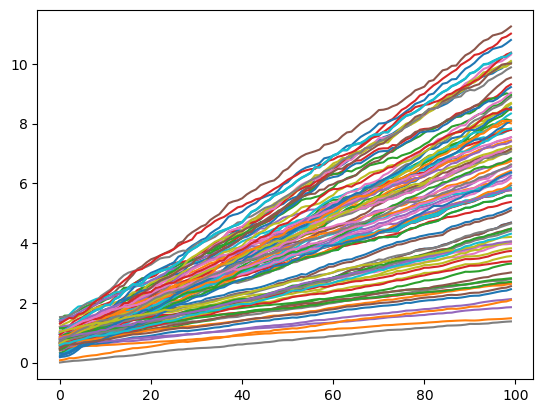

In [40]:
lin_episodes = np.empty((0, length))
for c in np.linspace(0.01, 0.1, 50):
    
    lin = LinearDegradation(length=length, dim=1, c=c, mu_e=0, sigma_e=c/2)
    episodes_i = lin.generate_episode(x0=np.abs(np.random.randn(n0)*0.3+0.7))  # Initial crack lengths in meters
    lin_episodes = np.concatenate([lin_episodes, episodes_i], axis=0)

#drop invalid values
lin_episodes = lin_episodes[~np.isnan(lin_episodes).any(axis=1)]
lin_episodes = lin_episodes[(lin_episodes<15).all(axis=1)]
lin_episodes = lin_episodes[(lin_episodes>=0).all(axis=1)]

# plot 20 random episodes
plt.plot(lin_episodes[np.random.randint(0, lin_episodes.shape[0], size=100)].T)
lin_episodes.min(), lin_episodes.max(), lin_episodes.shape

In [41]:
np.linspace(2, 7, 5)

array([2.  , 3.25, 4.5 , 5.75, 7.  ])

(np.float64(0.007107266666894874), np.float64(14.221687868176208), (480, 100))

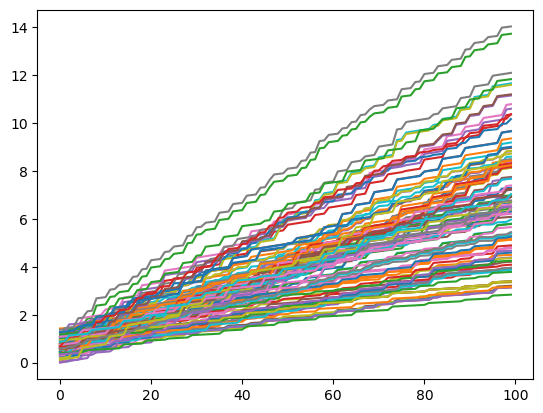

In [42]:
shock_episodes = np.empty((0, length))
for mu_t in range(2, 7):
    for mu_shock in np.linspace(0.1, 0.3, 5):
        shock = RandomShockDegradation(length=length, dim=1, 
                                       mu_t=mu_t, sigma_t=mu_t/3, 
                                       mu_shock=mu_shock, sigma_shock=mu_shock/3, 
                                       baseline=mu_shock/10)
        
        episodes_i = shock.generate_episode(x0=np.abs(np.random.randn(n0)*0.3+0.7))  # Initial crack lengths in meters
        shock_episodes = np.concatenate([shock_episodes, episodes_i], axis=0)

#drop invalid values
shock_episodes = shock_episodes[~np.isnan(shock_episodes).any(axis=1)]
shock_episodes = shock_episodes[(shock_episodes<15).all(axis=1)]
shock_episodes = shock_episodes[(shock_episodes>=0).all(axis=1)]

shock_episodes.shape
# plot 20 random episodes
plt.plot(shock_episodes[np.random.randint(0, shock_episodes.shape[0], size=100)].T)
shock_episodes.min(), shock_episodes.max(), shock_episodes.shape

(np.float64(0.030207659848825563), np.float64(14.987683566882323), (992, 100))

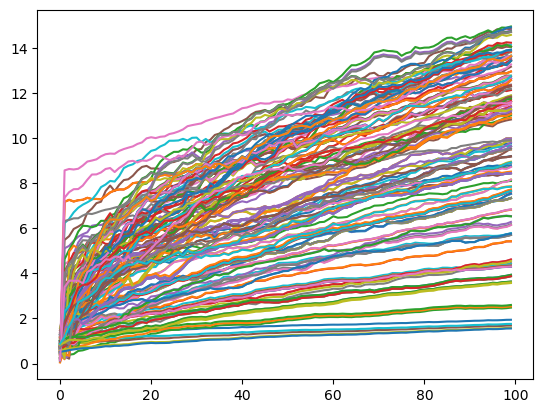

In [43]:
sei_episodes = np.empty((0, length))
for k in np.linspace(0.01, 2, 100):
    
    sei = SEILayer(length=length, dim=1, k=k, sigma_e=1)
    
    episodes_i = sei.generate_episode(x0=np.abs(np.random.randn(n0)*0.3+0.7))  # Initial crack lengths in meters
    sei_episodes = np.concatenate([sei_episodes, episodes_i], axis=0)

#drop invalid values
sei_episodes = sei_episodes[~np.isnan(sei_episodes).any(axis=1)]
sei_episodes = sei_episodes[(sei_episodes<15).all(axis=1)]
sei_episodes = sei_episodes[(sei_episodes>=0).all(axis=1)]

sei_episodes.shape
# plot 20 random episodes
plt.plot(sei_episodes[np.random.randint(0, sei_episodes.shape[0], size=200)].T)
sei_episodes.min(), sei_episodes.max(), sei_episodes.shape

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:92: RuntimeWarning:

overflow encountered in multiply



(np.float64(0.01353484320958889), np.float64(14.971971349908369), (147, 100))

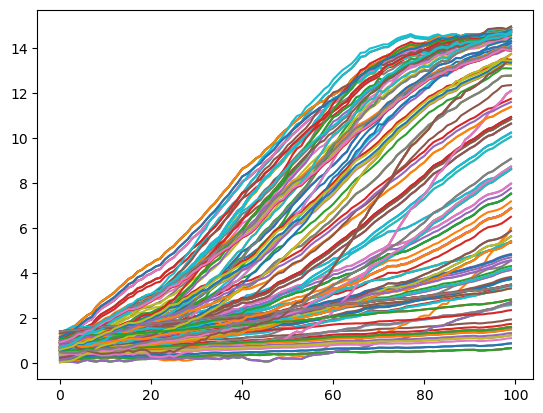

In [44]:
logistic_episodes = np.empty((0, length))
for alfa in np.linspace(0.01, .4, 40):
    
    logstiff = LogisticStiffness(length=length, dim=1, alfa=alfa, xmax=15, sigma_e=alfa)
    
    episodes_i = logstiff.generate_episode(x0=np.abs(np.random.randn(n0)*0.3+0.7))  # Initial crack lengths in meters
    logistic_episodes = np.concatenate([logistic_episodes, episodes_i], axis=0)

#drop invalid values
logistic_episodes = logistic_episodes[~np.isnan(logistic_episodes).any(axis=1)]
logistic_episodes = logistic_episodes[(logistic_episodes<15).all(axis=1)]
logistic_episodes = logistic_episodes[(logistic_episodes>=0).all(axis=1)]

logistic_episodes.shape
# plot 20 random episodes
plt.plot(logistic_episodes[np.random.randint(0, logistic_episodes.shape[0], size=200)].T)
logistic_episodes.min(), logistic_episodes.max(), logistic_episodes.shape

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:116: RuntimeWarning:

invalid value encountered in power



(np.float64(0.004098601061376797), np.float64(12.464840242486448), (619, 100))

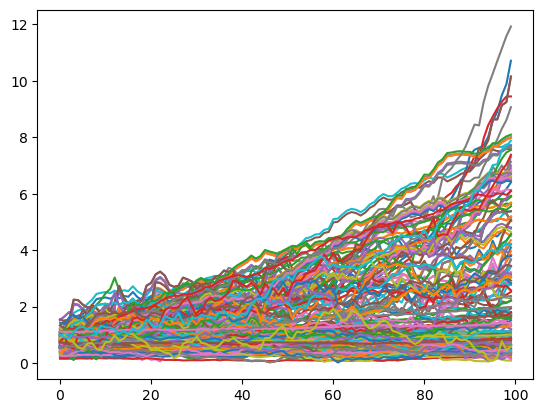

In [45]:
loglogistic_episodes = np.empty((0, length))
for beta in np.linspace(0.01, .3, 8):
    for k in np.linspace(-0.9, .9, 8):
    
        logstiff = LogLogisticStiffness(length=length, dim=1, alfa=15, beta=beta, k=k, sigma_e=beta)
        
        episodes_i = logstiff.generate_episode(x0=np.abs(np.random.randn(n0)*0.3+0.7))  # Initial crack lengths in meters
        loglogistic_episodes = np.concatenate([loglogistic_episodes, episodes_i], axis=0)

#drop invalid values
loglogistic_episodes = loglogistic_episodes[~np.isnan(loglogistic_episodes).any(axis=1)]
loglogistic_episodes = loglogistic_episodes[(loglogistic_episodes<15).all(axis=1)]
loglogistic_episodes = loglogistic_episodes[(loglogistic_episodes>=0).all(axis=1)]

loglogistic_episodes.shape
# plot 20 random episodes
plt.plot(loglogistic_episodes[np.random.randint(0, loglogistic_episodes.shape[0], size=200)].T)
loglogistic_episodes.min(), loglogistic_episodes.max(), loglogistic_episodes.shape

In [46]:
episodes = np.concatenate([lin_episodes, shock_episodes, paris_episodes, sei_episodes, logistic_episodes, loglogistic_episodes], axis=0)

In [47]:

# Check default device
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
#device = torch.device('cpu')  # Force CPU for consistency in this example
print("Default Device:", device)

Default Device: mps


In [48]:
print(f"Min: {episodes.min()}")
print(f"Max: {episodes.max()}")

Min: 0.0012982286645160102
Max: 14.987683566882323


# Set up model and training params

In [49]:
vocab_size=1000
context_window=40
bs = 32
# Split episodes into train/test (e.g., 80/20)
# Shuffle indices
shuffled_indices = np.random.permutation(len(episodes))

# Apply shuffled indices
shuffled_episodes = episodes[shuffled_indices]

n_train = int(0.8 * len(episodes))
train_episodes = shuffled_episodes[:n_train]
test_episodes = shuffled_episodes[n_train:]
train_dataset = TimeSeriesDataset(train_episodes, context_window=context_window, vocab_size=vocab_size)
test_dataset = TimeSeriesDataset(test_episodes, context_window=context_window, vocab_size=vocab_size)
len(train_dataset), len(test_dataset)

(200400, 50100)

In [50]:
train_episodes.shape, test_episodes.shape

((3340, 100), (835, 100))

In [51]:
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=2)
len(train_loader), len(test_loader)

(6263, 1566)

In [52]:
model = DegradationTransformer(vocab_size=vocab_size, context_window=context_window, 
                               embedding_dim=64, num_heads=8, num_blocks=3)
# model param count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 215,744 trainable parameters


In [53]:
# get lr form learner


In [54]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()
len(train_loader), len(test_loader)
cbs = [ProgressCallback(50), SaveModel()]
learner = Learner(model, optim, loss_func, train_loader, test_loader, cbs, device=device)
learner.fit(1)

In [55]:
example_input = torch.randn(
    1, learner.model.context_window,
    device=device
)
# make example_input of type long
example_input = example_input.long()
# Generate example output (forward pass, no grad)
with torch.no_grad():
    example_output = learner.model(example_input)

In [56]:
example_input, example_output.shape

(tensor([[ 0,  0, -1,  0,  0, -1,  0,  0,  0, -3,  0,  1,  0,  1,  0, -1,  0,  1,
           0,  0,  1,  0,  0,  2,  0, -1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  1, -1]], device='mps:0'),
 torch.Size([1, 1000]))

# Model evaluation

((2, 100), 100)

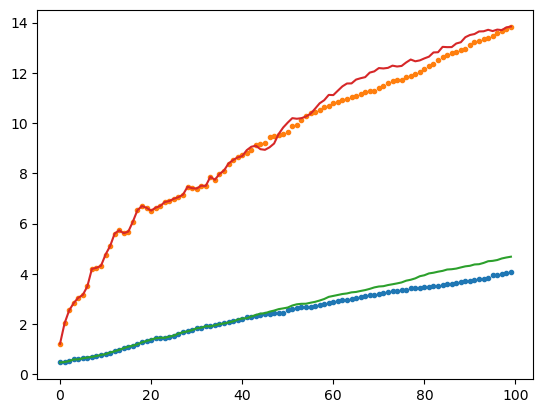

In [98]:
learner1 = Learner(model, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])
inexces = np.random.randint(0, test_episodes.shape[0], size=2)

predictions = learner1.predict(test_episodes[inexces,:context_window], num_periods=100-context_window,temperature=0, top_k=1, top_p=None)


plt.plot(predictions.T, '.')
plt.plot(test_episodes[inexces, ].T)

predictions.shape, len(log_probs)

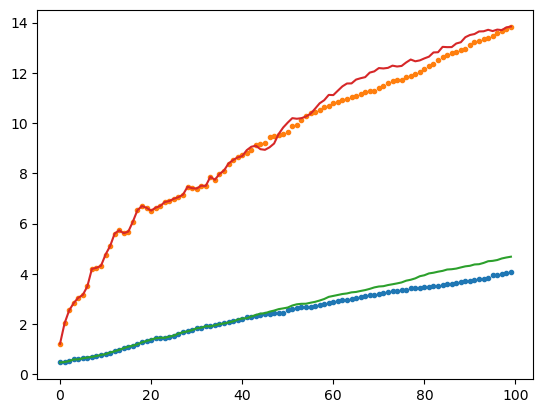

In [99]:
predicted = learner.predict(test_episodes[inexces,:context_window], num_periods=100-context_window, temperature=0.0, top_k=1, top_p=None)
plt.plot(predicted.T, '.')
plt.plot(test_episodes[inexces, ].T)

np.save('degradation_episodes.npy', test_episodes[inexces,:context_window])

In [84]:
test_episodes[inexces,:context_window].shape

(2, 40)

In [82]:
learner.predict??

Signature: learner.predict(x, num_periods=60, temperature=1.0, top_k=None, top_p=None)
Source:   
    def predict(self, x, num_periods=60, temperature=1.0, top_k=None, top_p=None):
        """
        Inference with the trained model (PyTorch version)
        
        Args:
            x: numpy array, 1D or 2D - initial context
            num_periods: int - number of future steps to predict
            temperature: float - sampling temperature
                - 0.0: greedy (argmax)
                - 1.0: sample from model distribution
                - >1.0: more random (flatter distribution)
            top_k: int or None - if set, only sample from top k tokens
            top_p: float or None - if set, nucleus sampling (sample from smallest set with cumulative prob > p)
        """
        self.model.eval()
        
        # Convert to torch and add batch dim if needed
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32, device=self.device)
   

In [81]:
predicted.shape

(2, 100)

## next token prediction accuracy

In [58]:
class TimeSeriesDatasetRaw(torch.utils.data.Dataset):
    def __init__(self, data, context_window, vocab_size):
        self.data = data
        self.context_window = context_window
        self.vocab_size = vocab_size
        self.n_episodes, self.episode_length = data.shape
        self.samples_per_episode = self.episode_length - context_window
        self.normalizer = WindowNormalizer()
        self.digitizer = UniformDigitizer(vocab_size)
    def __len__(self):
        return self.n_episodes * self.samples_per_episode
    
    def __getitem__(self, idx):
        

        idx_array = np.atleast_1d(idx)
        single_sample = np.isscalar(idx)

        episode_idx = idx_array // self.samples_per_episode
        pos = idx_array % self.samples_per_episode

        # Correct slicing for variable positions
        x = np.stack([self.data[e, p:p+self.context_window] for e, p in zip(episode_idx, pos)])
        y = np.array([self.data[e, p+self.context_window] for e, p in zip(episode_idx, pos)])

        # Convert to tensors
        x_tensor = torch.tensor(x, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.float).squeeze()

        if single_sample:
            x_tensor = x_tensor[0]
            y_tensor = y_tensor[0]

        return x_tensor, y_tensor




In [59]:
train_episodes.shape, test_episodes.shape

((3340, 100), (835, 100))

In [60]:
import plotly.express as px
import pandas as pd

In [61]:
dataset_raw= TimeSeriesDatasetRaw(train_episodes, context_window=context_window, vocab_size=vocab_size)
x_batch, y_batch = dataset_raw[range(5_000)]


print(x_batch.shape)

y_predict = learner.predict(x_batch, num_periods=1)[:, -1]




df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Train data - Next Token Prediction Accuracy')
fig.show()

torch.Size([5000, 40])


does the plot above means we need a bit of regularization, it seems we are fitting to noise??

we are also overfitting to the near-zero scienarios, most of which are paris episodes??!


Text(0.5, 1.0, 'Train data - Next Token Prediction Accuracy')

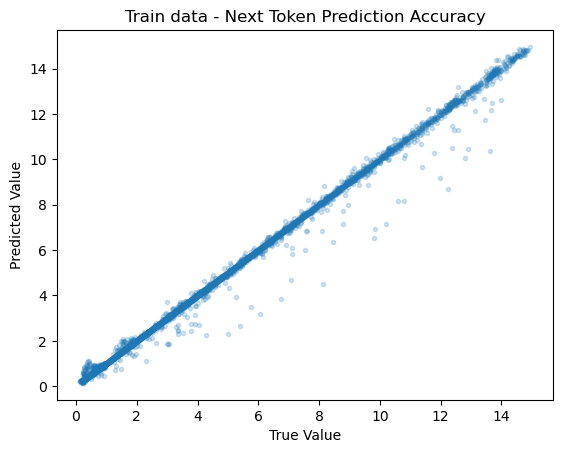

In [62]:
plt.plot(y_batch, y_predict, '.', alpha=0.2)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Train data - Next Token Prediction Accuracy')

In [63]:
dataset_raw= TimeSeriesDatasetRaw(test_episodes, context_window=context_window, vocab_size=vocab_size)
x_batch, y_batch = dataset_raw[range(5_000)]


print(x_batch.shape)

y_predict = learner.predict(x_batch, num_periods=1)[:, -1]


df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

torch.Size([5000, 40])


Text(0, 0.5, 'Predicted Value')

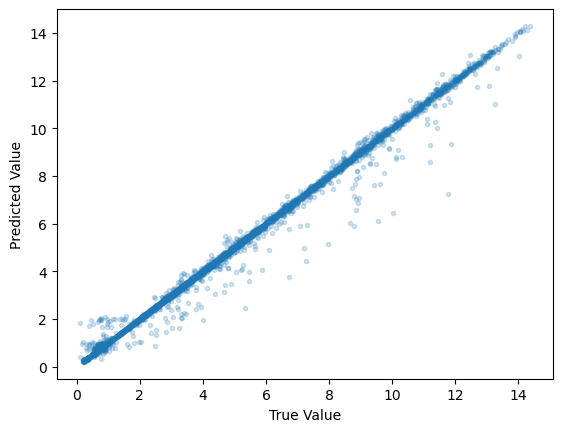

In [64]:
plt.plot(y_batch, y_predict, '.', alpha=0.2)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

# test model loading from local file

In [65]:
from safetensors.torch import load_model
import json
with open("degradation_transformer_model_config.json", "rb") as f:
    model_params=json.load(f)

model1 = DegradationTransformer(vocab_size=model_params['vocab_size'], 
                                context_window=model_params['context_window'], 
                               embedding_dim=model_params['embedding_dim'], 
                               num_heads=model_params['num_heads'],
                                 num_blocks=model_params['num_blocks'])
load_model(model1, "degradation_transformer_model.safetensors")
model1.eval()
learner1 = Learner(model1, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])

y_predict = learner1.predict(x_batch, num_periods=1)[:, -1]


df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

## test model load from wandb

In [66]:
import wandb
import os
api = wandb.Api()
artifact = api.artifact('smasadzadeh-freelancer/degradation-transformer/degradation-transformer-model:Production')

artifact_dir = artifact.download()

safetensor_filename="degradation_transformer_model.safetensors"
config_filename="degradation_transformer_model_config.json"

model_weights_path = os.path.join(artifact_dir, safetensor_filename)
config_path = os.path.join(artifact_dir, config_filename)

# Load config and create model
model_params = json.load(open(config_path))
model3 = DegradationTransformer(**model_params)
load_model(model3, model_weights_path)

learner3 = Learner(model3, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])

y_predict = learner3.predict(x_batch, num_periods=1)[:, -1]



df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

wandb:   2 of 2 files downloaded.  


# test model loading from hf

this could be a differnet model than what we train here before pushing code to github

In [67]:
from huggingface_hub import hf_hub_download
file_path = hf_hub_download(
    repo_id="smasadzadeh/degradation-transformer",
    filename="degradation_transformer_model.safetensors"
)

config_file_path = hf_hub_download(
    repo_id="smasadzadeh/degradation-transformer",
    filename="degradation_transformer_model_config.json"
)



model_params = json.load(open(config_file_path, "rb"))
# import DegradationTransformer class from utils_file_path

model2 = DegradationTransformer(vocab_size=model_params['vocab_size'], 
                                context_window=model_params['context_window'], 
                               embedding_dim=model_params['embedding_dim'], 
                               num_heads=model_params['num_heads'],
                                 num_blocks=model_params['num_blocks'])
load_model(model2, file_path)


learner2 = Learner(model2, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])

y_predict = learner2.predict(x_batch, num_periods=1)[:, -1]



df=pd.DataFrame([y_batch, y_predict]).T
df.columns = ['True Value', 'Predicted Value']
fig = px.line(df, labels={ 'x':['Predicted Value','Predicted Value']}, title='Test data - Next Token Prediction Accuracy')
fig.show()

degradation_transformer_model.safetensor(…):   0%|          | 0.00/867k [00:00<?, ?B/s]